# Analiza wybranego zbioru danych (mini projekt) - Youtube Trending videos

Dane zostały pozyskane z portalu Kaggle. Zbiór danych o nazwie "Trending YouTube Video Statistics" został oryginalnie udostępniony pod poniższym adresem https://www.kaggle.com/datasnaek/youtube-new

Analizie poddano dane dotyczącze filmików ze Stanów Zjednoczonych zebrane w pliku USvideos.csv

Zgodnie z wymogami projektu plik ten został zapisany w bazie SQLite (w utworzonej w tym celu bazie danych - DatabaseYT.db)

# Czyszczenie danych

SQLite nie posiada formatu Bool. Wartości True i False zostały automatycznie odczytane przez bazę w formacie String, dlatego wartości True zostały podmienione w bazie manualnie na 1, a wartości False na 0. Dotyczy to trzech kolumn: comments_disabled, ratings_disabled, video_error_or_removed. Powodem tej zamiany jest konieczność posiadania wartości logicznych przy selectach z bazy.

# Wstępna analiza danych

In [75]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import date
import calendar
import json
import statistics

Połączenie do bazy danych

In [76]:
db = sqlite3.connect('DatabaseYT.db')

In [77]:
sql_all = "Select * from videos"

Wczytanie danych do DataFrame oraz sparsowanie zmiennych trending_date i publish_time do formatu datetime64

In [78]:
df = pd.read_sql_query(sql_all, db, parse_dates={'trending_date': '%y.%d.%m', 'publish_time': '%Y-%m-%dT%H:%M:%S.%fZ'})
pd.set_option('float_format', '{:.0f}'.format)
df[["comments_disabled", "ratings_disabled", "video_error_or_removed"]] = df[["comments_disabled", "ratings_disabled", "video_error_or_removed"]].astype(bool)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null datetime64[ns]
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null datetime64[ns]
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40949 non-null object
dtypes: bool(3), datetime64[ns](2), int64(5), object(6)
memory usage: 4.2+ MB


Plik zawiera 40949 rekordów dla których zebrano dane o 16 zmiennych.

In [80]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,last week tonight trump presidency|last week t...,2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24,racist superman|rudy|mancuso|king|bach|racist|...,3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04,rhett and link|gmm|good mythical morning|rhett...,343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [81]:
df[['views','likes', 'dislikes', 'comment_count']].describe()

,views,likes,dislikes,comment_count
count,40949,40949,40949,40949
mean,2360785,74267,3711,8447
std,7394114,228885,29030,37430
min,549,0,0,0
25%,242329,5424,202,614
50%,681861,18091,631,1856
75%,1823157,55417,1938,5755
max,225211923,5613827,1674420,1361580


Podstawowe statystki dla zmiennych liczbowych wskazują na duży rozrzut danych (zliustrownay na poniższych wykresach).

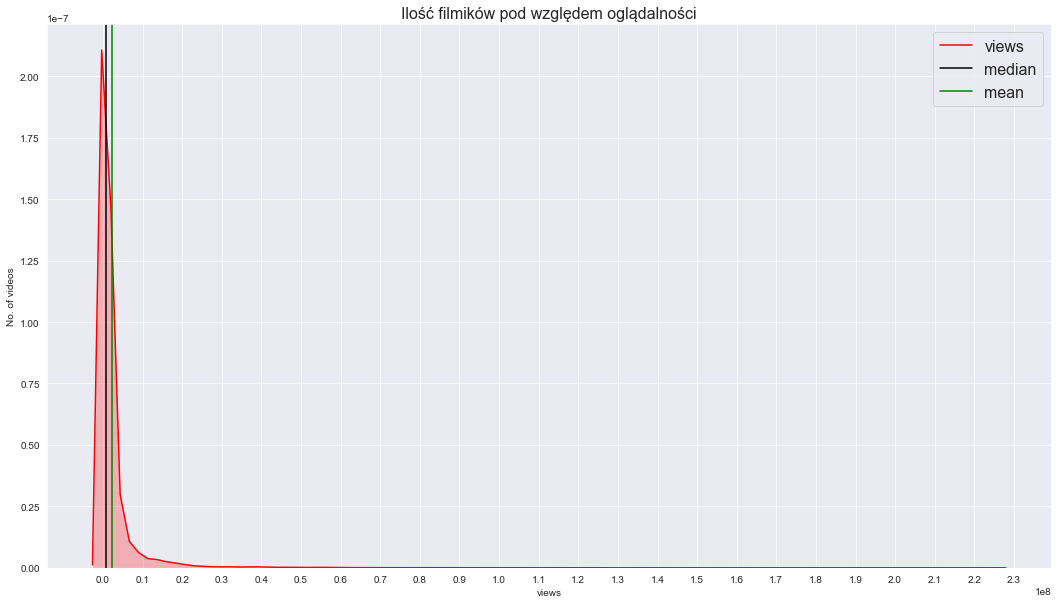

In [82]:
fig, ax = plt.subplots(figsize=(18, 10))

_ = sns.kdeplot(df["views"], color="red", shade=True)
_ = ax.set(xlabel="views", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = sns.set_style('darkgrid')
_ = plt.title("Ilość filmików pod względem oglądalności", fontsize =16)
_ = plt.axvline(statistics.median(df["views"]), label = 'median', color="black")
_ = plt.axvline(statistics.mean(df["views"]), label = 'mean', color="green")
_ = plt.legend(fontsize=16)

plt.show()

Zdecydowana większość wyników ma oglądalność mniejszą niż średnia wynosząca 2 360 785. Aż 75% filmików mieści się w przedziale do 1 823 157 wyświetleń - jest to rozkład prawoskośny. Świadczy to o występowaniu wartości skrajnych - stosunkowo niewielkiej ilości filmików z bardzo dużą oglądalnością, co wpływa na stosunkowo wysoką średnią. Mediana ogląlności wynosi tylko 681 861, co oznacza, że połowa analizwanych filmików nie osiąga wiekszej oglądalności w danym dniu badanego okresu.

W celu bliższego przyjrzenia rozkładowi danych, odfiltrowano wartości najbardziej skrajne.

9017286


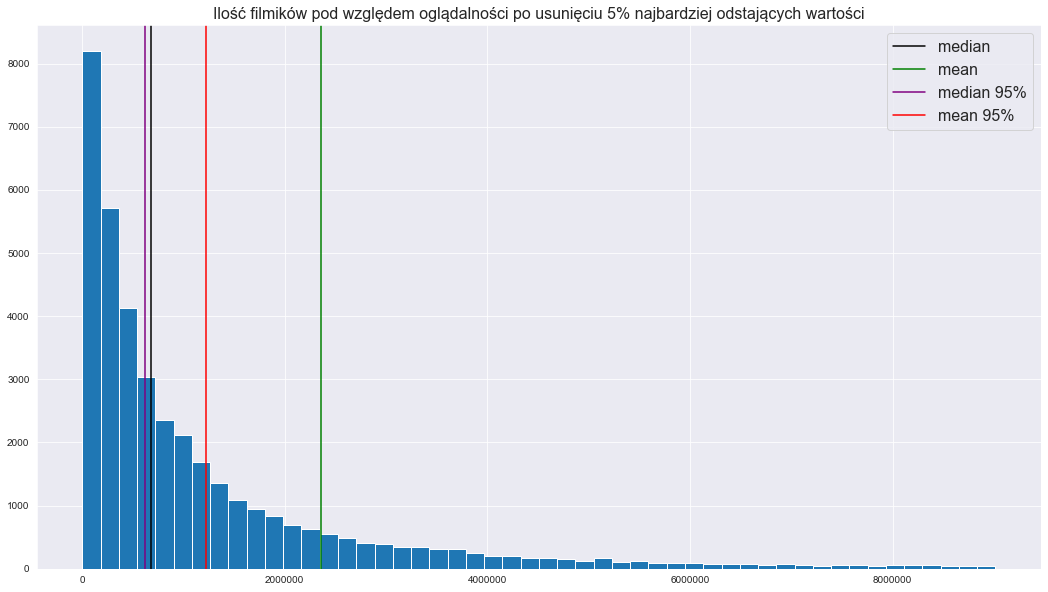

In [83]:
filter_views=np.percentile(df["views"], 95)
filter_views =int(filter_views)
print(filter_views)

fig, ax = plt.subplots(figsize=(18, 10))

filtered_views = df[df["views"]<filter_views]
filtered_views["views"].hist(bins=50)
_ = plt.axvline(statistics.median(df["views"]), label = 'median', color="black")
_ = plt.axvline(statistics.mean(df["views"]), label = 'mean', color="green")
_ = plt.axvline(statistics.median(filtered_views["views"]), label = 'median 95%', color="purple")
_ = plt.axvline(statistics.mean(filtered_views["views"]), label = 'mean 95%', color="red")
_ = plt.title("Ilość filmików pod względem oglądalności po usunięciu 5% najbardziej odstających wartości", fontsize =16)
_ = plt.legend(fontsize=16)
_ = plt.show()

95% wszytkich filmików ma oglądaność mniejszą lub równą w przybliżeniu 9,017 mln.  Najpopularniejszy filmik był oglądany aż blisko 225,212 mln razy w danym dniu badanego okresu, co znacząco wpływa na średnią dla całej populacji.

In [84]:
df[df["views"]== df["views"].max()]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
38547,YOjWnS4cMY,2018-06-02,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06 04:00:07,Childish Gambino|Rap|This Is America|mcDJ Reco...,225211923,5023450,343541,517232,https://i.ytimg.com/vi/VYOjWnS4cMY/default.jpg,False,False,False,“This is America” by Childish Gambino http://s...


In [85]:
df[df["views"]== df["views"].min()]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
14335,y6KYFcta4SE,2018-01-26,"1 dead, others injured after Ky. school shooting",Newsy,25,2018-01-23 15:30:01,shooting|kentucky|breaking news|u.s. news|mars...,549,9,0,5,https://i.ytimg.com/vi/y6KYFcta4SE/default.jpg,False,False,False,Kentucky Gov. Matt Bevin confirmed there was a...


307402


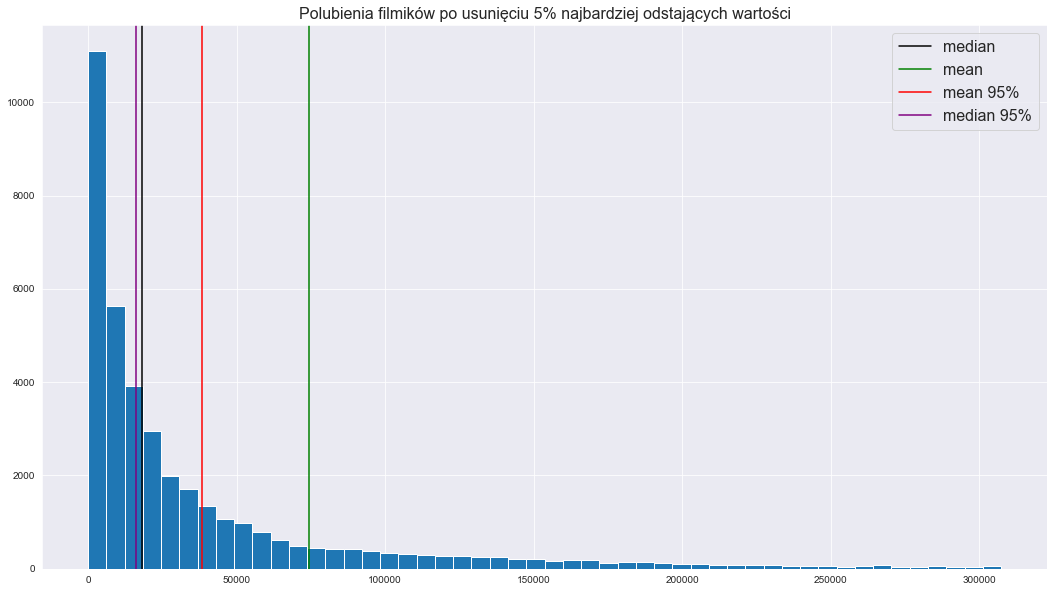

In [86]:
filter_likes=np.percentile(df["likes"], 95)
filtered_likes = df[df["likes"]<filter_likes]
print(int(filter_likes))

fig, ax = plt.subplots(figsize=(18, 10))
filtered_likes["likes"].hist(bins=50)
_ = plt.axvline(statistics.median(df["likes"]), label = 'median', color="black")
_ = plt.axvline(statistics.mean(df["likes"]), label = 'mean', color="green")
_ = plt.axvline(statistics.mean(filtered_likes["likes"]), label = 'mean 95%', color="red")
_ = plt.axvline(statistics.median(filtered_likes["likes"]), label = 'median 95%', color="purple")
_ = plt.title("Polubienia filmików po usunięciu 5% najbardziej odstających wartości", fontsize =16)
_ = plt.legend(fontsize=16)
_ = plt.show()

In [87]:
df[df["likes"]== df["likes"].max()]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
38273,C2z4GqqS5E,2018-06-01,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18 09:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄|FAKE LOVE|FAKE...,123010920,5613827,206892,1228655,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...


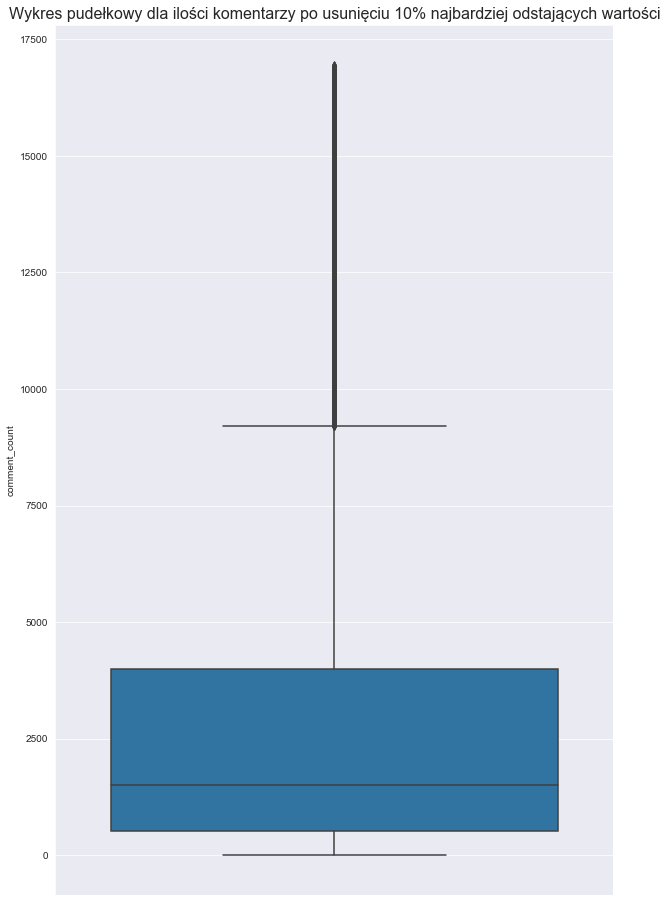

In [88]:
filter_comments=np.percentile(df["comment_count"], 90)
filtered_comments = df[df["comment_count"]<filter_comments]

fig, ax = plt.subplots(figsize=(10, 16))
ax = sns.boxplot(y="comment_count", data=filtered_comments)
_ = plt.title("Wykres pudełkowy dla ilości komentarzy po usunięciu 10% najbardziej odstających wartości", fontsize =16)
_ = plt.show()

In [89]:
df[df["comment_count"]== df["comment_count"].max()]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
11323,QwZT7T-TXT0,2018-01-09,So Sorry.,Logan Paul Vlogs,24,2018-01-02 16:42:21,logan paul vlog|logan paul|logan|paul|olympics...,37539570,1402578,1674420,1361580,https://i.ytimg.com/vi/QwZT7T-TXT0/default.jpg,False,False,False,


Najczęściej komentowanym filmikiem (1 361 580 komentarzy) jest filmik pod tytułem "So Sorry." pojawiający się w zestawieniu Trednings 9 stycznia 2018. 75% wszystkich fimików nie ma większej ilości komentarzy niż 5 755. Mediana wynosi tylko 1 856 komentarzy.

In [90]:
sql_video_id_count = "Select count(distinct video_id) as ilość_filmików from videos"
ilość_filmików_df = pd.read_sql_query(sql_video_id_count, db)
print(ilość_filmików_df)


   ilość_filmików
0            6500


In [91]:
len(df.video_id.unique())

6500

In [92]:
df.video_id.value_counts()

4KvrAUjn6c     30
-3iathMo7o     29
ILJvqrAQ_w     29
BL8IRJ5yHU     29
h--kFui1JA     29
               ..
UuETCtbExnM     1
hX643KbiI4s     1
0R9wQAFBbI      1
unX4FQqM6vI     1
mRo6MnXObuE     1
Name: video_id, Length: 6500, dtype: int64

Zbiór zawiera dane o 6500 filmików z unikalnymi id, z czego najpopularniejszy fimik pojawił się w zestawieniu trending 30 razy, a te najmniej popularne tylko raz.

In [93]:
df.title.value_counts()

WE MADE OUR MOM CRY...HER DREAM CAME TRUE!                                      30
Rooster Teeth Animated Adventures - Millie So Serious                           29
Charlie Puth - BOY [Official Audio]                                             29
Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures    29
Sam Smith - Pray (Official Video) ft. Logic                                     29
                                                                                ..
Types of People at Weddings                                                      1
I Picked My Girlfriend's Outfit Blindfolded                                      1
Jennifer Hudson Is Christmas' Biggest Fan                                        1
Hilarious Pub Prank || ViralHog                                                  1
Narcos - Season 4 | Teaser [HD] I Netflix                                        1
Name: title, Length: 6455, dtype: int64

Liczba unikalnych tytułów filmików wynosi 6455. Jest mniejesza o 45 niż liczba filmików z uniklanym id. Zatem część z filmików z tym samym tytułem ma więcej niż jedno id.

# Analiza Trending date

In [94]:
first_day = df['trending_date'].min()
last_day = df['trending_date'].max()

In [95]:
print('first day: ', first_day)
print('last day: ', last_day)
print((last_day - first_day).days)

first day:  2017-11-14 00:00:00
last day:  2018-06-14 00:00:00
212


In [96]:
df.trending_date.value_counts()

2017-12-27    200
2018-04-19    200
2017-11-14    200
2017-11-27    200
2017-12-10    200
             ... 
2018-01-31    197
2018-02-01    197
2018-02-03    196
2018-02-02    196
2018-02-04    196
Name: trending_date, Length: 205, dtype: int64

Zestawienie objemuje okres od 14 listopada 2017 do 14 czerwca 2018. Jest to okres 212 dni, ale zestawnie zawiera dane dla 205 dni z tego okresu. Ilość filmików w zestawniu Trednings w każdym badaym dniu waha się pomiędzy 200 a 196.

In [97]:
groupby_month = df.groupby(['trending_date']).count().groupby(pd.Grouper(freq="M")).sum()

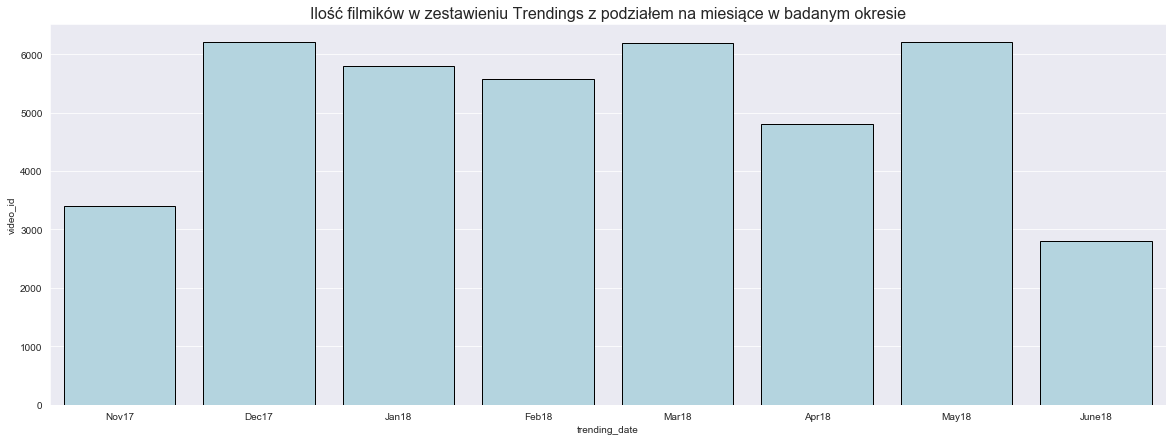

In [98]:
fig, ax = plt.subplots(figsize=(20, 7))

groupby_month.set_index(groupby_month.index, inplace=True)
_ = sns.barplot(groupby_month.index, groupby_month["video_id"],  color = "lightblue", edgecolor='black')
_ = plt.title('Ilość filmików w zestawieniu Trendings z podziałem na miesiące w badanym okresie',fontsize=16)

labels = ["Nov17", "Dec17", "Jan18", "Feb18", "Mar18", "Apr18", "May18", "June18"]
_ = plt.xticks(np.arange(len(labels)), labels)

_ = plt.show()

In [99]:
groupby_month

,video_id,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
trending_date,,,,,,,,,,,,,,,
2017-11-30,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400
2017-12-31,6200,6200,6200,6200,6200,6200,6200,6200,6200,6200,6200,6200,6200,6200,6200
2018-01-31,5796,5796,5796,5796,5796,5796,5796,5796,5796,5796,5796,5796,5796,5796,5796
2018-02-28,5571,5571,5571,5571,5571,5571,5571,5571,5571,5571,5571,5571,5571,5571,5571
2018-03-31,6183,6183,6183,6183,6183,6183,6183,6183,6183,6183,6183,6183,6183,6183,6183
2018-04-30,4800,4800,4800,4800,4800,4800,4800,4800,4800,4800,4800,4800,4800,4800,4800
2018-05-31,6199,6199,6199,6199,6199,6199,6199,6199,6199,6199,6199,6199,6199,6199,6199
2018-06-30,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800


# Analiza czasu publikacji filmików

   index  publish_year
0   2018         30279
1   2017         10428
2   2013            44
3   2015            35
4   2016            35
5   2014            32
6   2011            27
7   2012            24
8   2010            19
9   2009            14
10  2008            11
11  2006             1


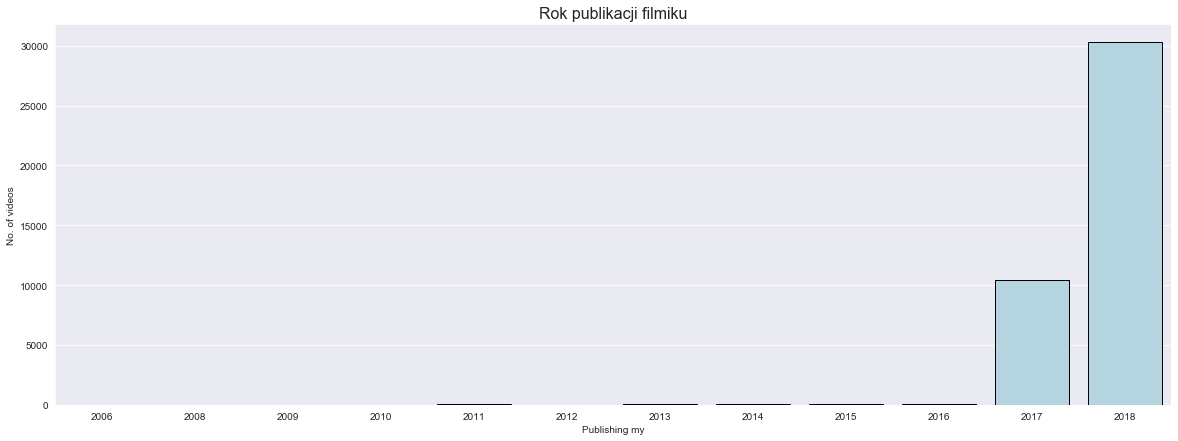

In [100]:
df["publish_year"] = df["publish_time"].apply(lambda x: x.strftime("%Y"))

my_summary = df["publish_year"].value_counts().to_frame().reset_index()
print(my_summary)
                                            
fig, ax = plt.subplots(figsize=(20, 7))
_ = sns.barplot(x="index", y="publish_year", data=my_summary, ax=ax, color = "lightblue", edgecolor='black')
_ = ax.set(xlabel="Publishing my", ylabel="No. of videos")
_ = ax.set_title('Rok publikacji filmiku', fontsize =16)
_ = plt.show()       
                              
                                    

Zdecydowanie najczęściej w zestawniue Trednings pojawiają się filmiki opublikowane stosunkowo niedawno od pojawienia się w zestawniu Trendnings.

       index  publish_day
0     Friday         7002
1   Thursday         6950
2    Tuesday         6786
3  Wednesday         6762
4     Monday         6177
5     Sunday         3679
6   Saturday         3593


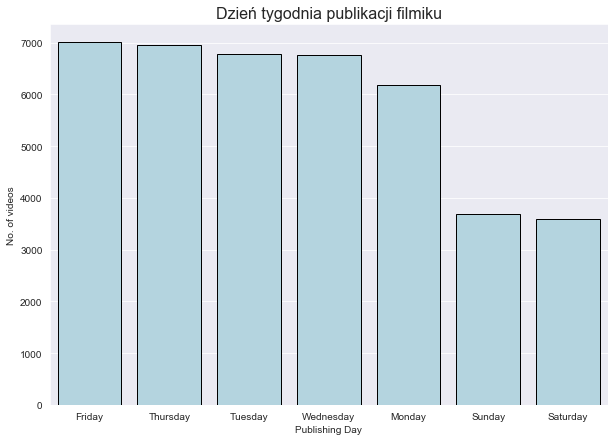

In [101]:
df["publish_day"] = df["publish_time"].apply(lambda x: x.strftime('%A'))

week_day_summary = df["publish_day"].value_counts().to_frame().reset_index()
print(week_day_summary)

fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.barplot(x="index", y="publish_day", data=week_day_summary, ax=ax, color = "lightblue", edgecolor='black')
_ = ax.set(xlabel="Publishing Day", ylabel="No. of videos")
_ = ax.set_title('Dzień tygodnia publikacji filmiku', fontsize =16)
_ = plt.show()

Najwięcej filmików jest publikowane w piątek (7002). Blisko o połowę mniej publikuje się w soboty i niedziele.

   index  publish_hour
0     16          3669
1     15          3483
2     17          3447
3     18          2889
4     14          2807
5     20          2136
6     19          2132
7     13          2105
8     21          2104
9     22          1959
10    12          1551
11    23          1495
12    00          1436
13    01          1318
14    04          1262
15    05          1253
16    03           944
17    02           936
18    11           856
19    08           790
20    07           700
21    09           605
22    10           541
23    06           531


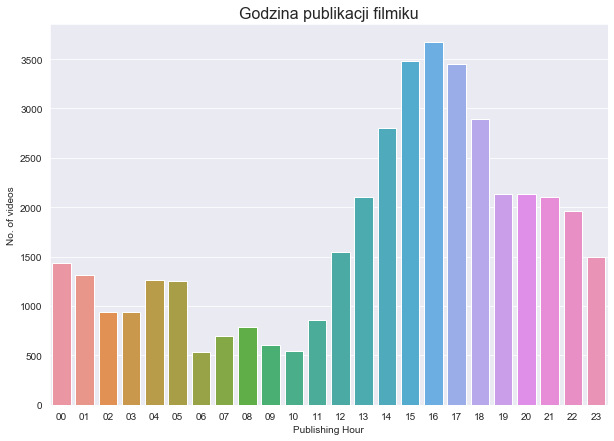

In [102]:
df["publish_hour"] = df["publish_time"].apply(lambda x: x.strftime('%H'))

hour_summary = df["publish_hour"].value_counts().to_frame().reset_index()
print(hour_summary)

fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.barplot(x="index", y="publish_hour", data=hour_summary, ax=ax)
_ = ax.set(xlabel="Publishing Hour", ylabel="No. of videos")
_ = ax.set_title('Godzina publikacji filmiku', fontsize =16)
_ = plt.show()

Zdecydowanie najczęściej popularne filmiki są publikowane w godzinach popłudniowych. Najrzadziej filmiki publikowane są rano.

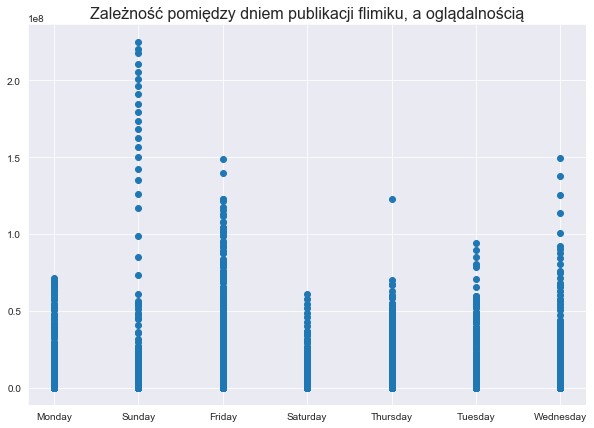

In [103]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = plt.scatter(df["publish_day"], df["views"])
_ = plt.title("Zależność pomiędzy dniem publikacji flimiku, a oglądalnością", fontsize =16)
_ = plt.show()

In [104]:
df.groupby('publish_day')["views"].describe()

,count,mean,std,min,25%,50%,75%,max
publish_day,,,,,,,,
Friday,7002,3373693,9695277,773,246993,766880,2296996,148689896
Monday,6177,1991128,5123672,687,227384,632018,1383096,71560694
Saturday,3593,1729033,3650120,1118,242796,664561,1842393,60635812
Sunday,3679,2953206,13559541,1722,300504,863116,2395397,225211923
Thursday,6950,2315077,5373310,884,279204,756481,1949585,122544931
Tuesday,6786,2053956,5581766,549,214796,620362,1721027,94254507
Wednesday,6762,2017862,6321770,658,209676,596096,1537300,149376127


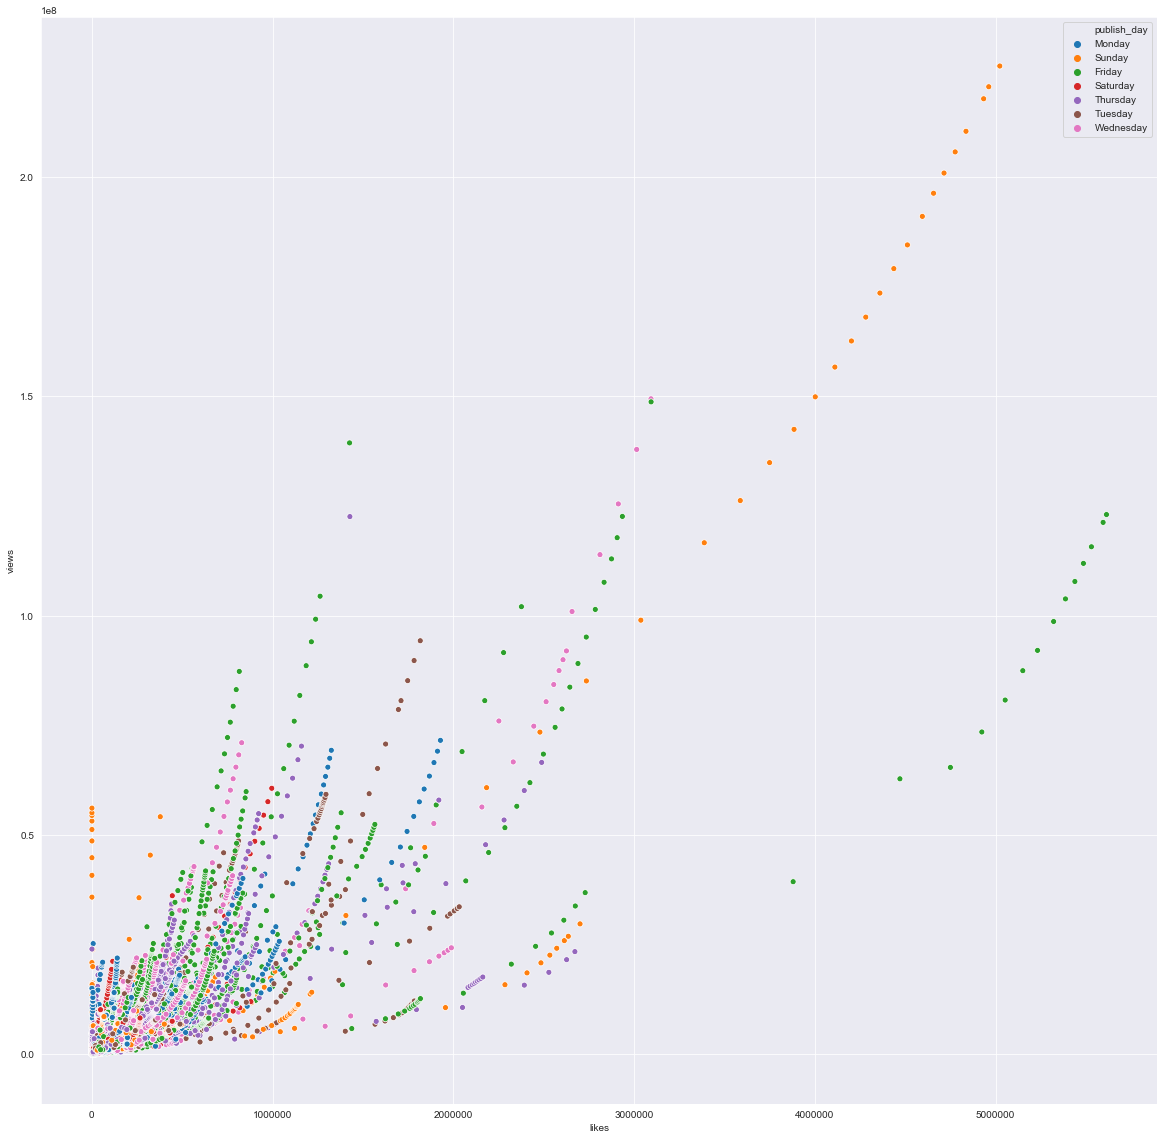

In [106]:
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.scatterplot(df["likes"], df["views"], hue="publish_day", data=df)

plt.show()

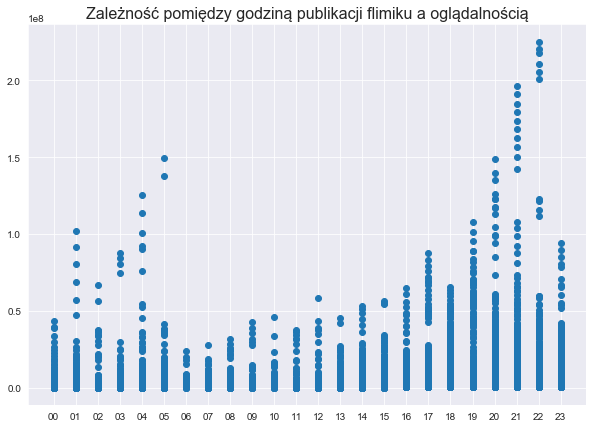

In [105]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = plt.scatter(df["publish_hour"].sort_values(), df["views"])
_ = plt.title("Zależność pomiędzy godziną publikacji flimiku a oglądalnością", fontsize =16)

_ = plt.show()

# Korelacja

Macierz korelacji pomiędzy zmiennymi ilościowymi i zmiennymi typu bool najlepiej przedstawia wykres typu heatmap.

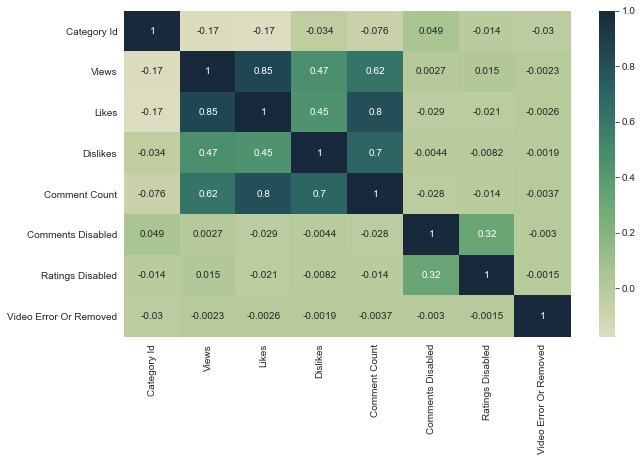

In [107]:
labels = [x.replace('_', ' ').title() for x in list(df.select_dtypes(include=['number', 'bool']).columns.values)]
fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.heatmap(df.corr(), annot=True, xticklabels=labels, yticklabels=labels,cmap=sns.cubehelix_palette(rot=-.6, as_cmap=True),ax=ax)
_ = plt.show()


Najsilniejsza dodatnia korelacja wynosząca 0.85 występuje pomiędzy zmiennymi "Likes" i "Views".

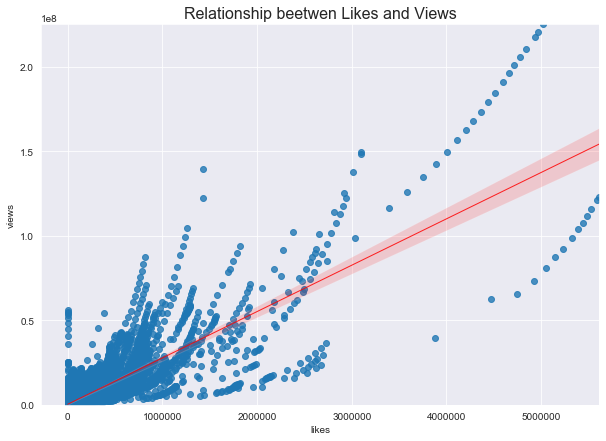

In [108]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.regplot(x=df["likes"], y=df["views"], line_kws={"color":"r","alpha":0.85,"lw":1})
_ = plt.title("Relationship beetwen Likes and Views", fontsize=16)
_ = ax.set_ylim(0, 225211923)
_ = plt.show()

Również istnieje dość silnie dodatnia korelacja wynosząca 0.8 pomiędzy ilością komentarzy a polubieniami.

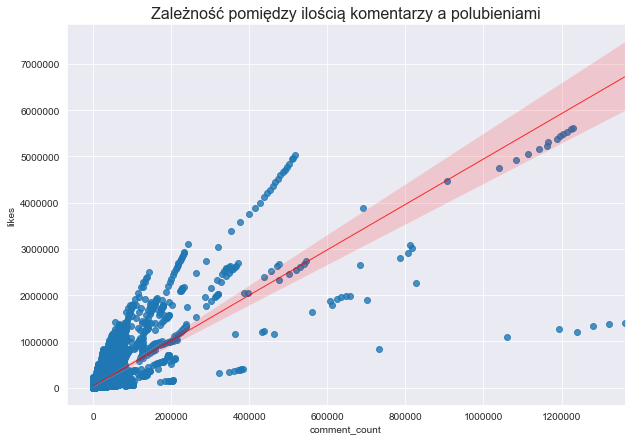

In [109]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.regplot(x=df["comment_count"], y=df["likes"], line_kws={"color":"r","alpha":0.8,"lw":1})
_ = plt.title("Zależność pomiędzy ilością komentarzy a polubieniami", fontsize=16)

_ = plt.show()

Ilość komentarzy jest też skorelowana z ilością dislike'ów (jednak w nieco niższym stopniu niż z ilością polubień).

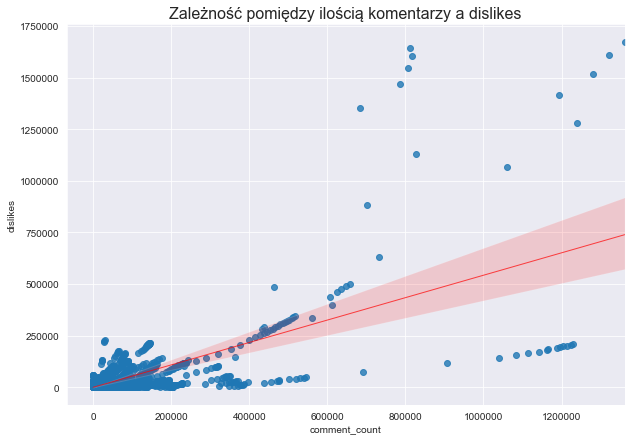

In [110]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.regplot(x=df["comment_count"], y=df["dislikes"], line_kws={"color":"r","alpha":0.7,"lw":1})
_ = plt.title("Zależność pomiędzy ilością komentarzy a dislikes", fontsize=16)

_ = plt.show()

Korelacja pomiędzy ilością komentarzy a oglądalnością wynosi 0.62

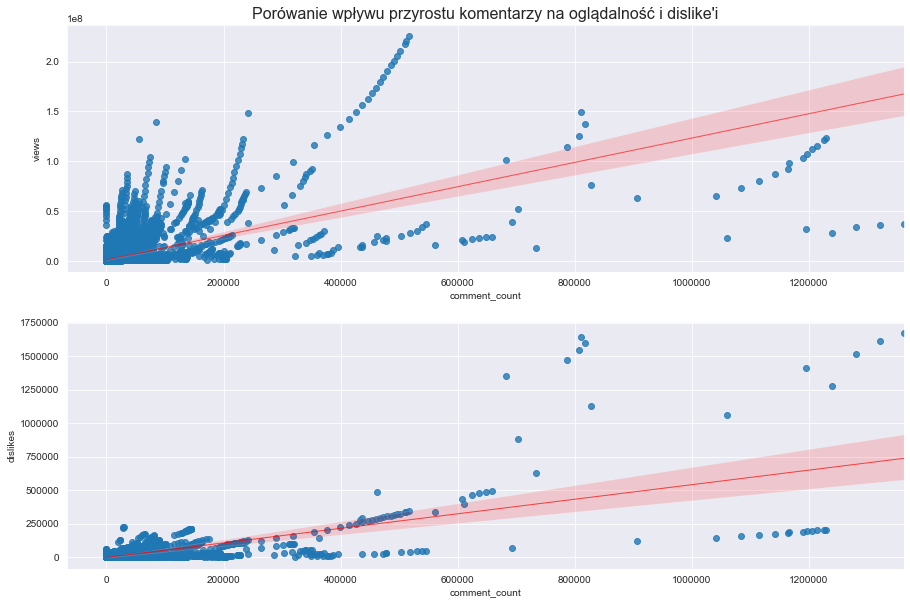

In [111]:
fig = plt.figure(figsize=(15, 10)) 

ax1 = plt.subplot(2,1,1)
_ = plt.title("Porówanie wpływu przyrostu komentarzy na oglądalność i dislike'i", fontsize=16)
ax1 = sns.regplot(x=df["comment_count"], y=df["views"], line_kws={"color":"r","alpha":0.62,"lw":1})
ax2 = plt.subplot(2,1,2)
ax2 = sns.regplot(x=df["comment_count"], y=df["dislikes"], line_kws={"color":"r","alpha":0.7,"lw":1})

Ilość komentarzy jest silniej skorelowana z dislike'ami niż z oglądalnością.  

# Najpopularniejsze kanały

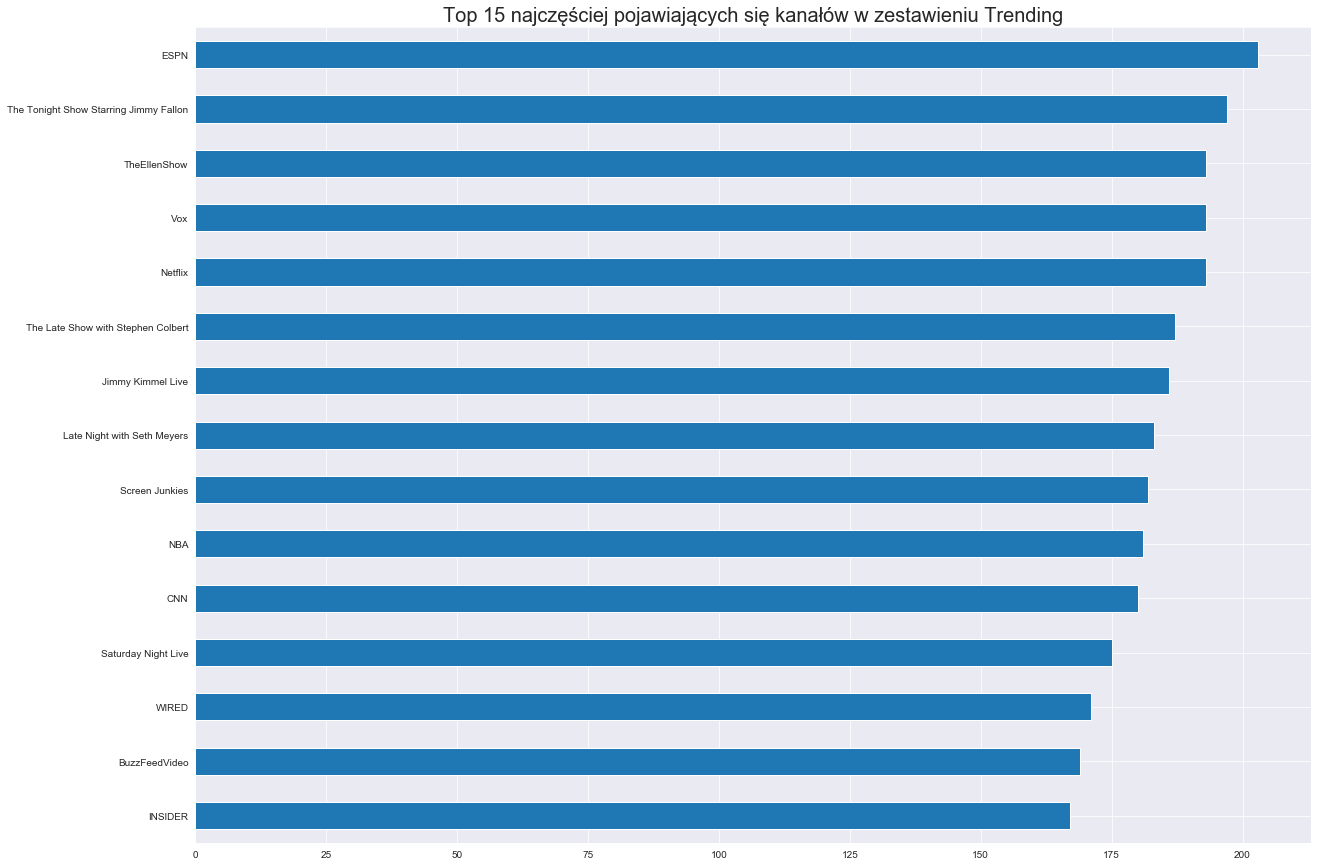

In [112]:
df['channel_title'].value_counts().head(15).sort_values().plot(kind='barh', figsize=(20,15))
plt.title("Top 15 najczęściej pojawiających się kanałów w zestawieniu Trending", size=20)
plt.show()

Najczęściej w zestawieniu pojawiają się fimiliki kanału ESPN - 203 razy.

In [113]:
df['channel_title'].value_counts().nlargest(15)

ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
Netflix                                   193
Vox                                       193
TheEllenShow                              193
The Late Show with Stephen Colbert        187
Jimmy Kimmel Live                         186
Late Night with Seth Meyers               183
Screen Junkies                            182
NBA                                       181
CNN                                       180
Saturday Night Live                       175
WIRED                                     171
BuzzFeedVideo                             169
INSIDER                                   167
Name: channel_title, dtype: int64

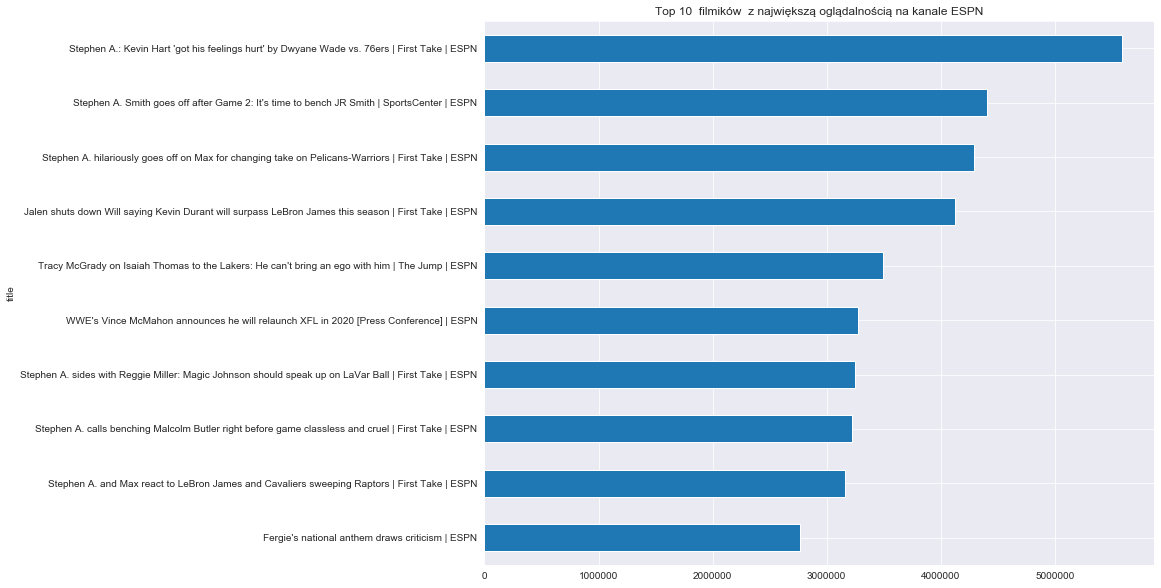

In [156]:
df[df["channel_title"]=="ESPN"].groupby("title")["views"].sum().nlargest(10).sort_values().plot(kind='barh', figsize=(12,10))
plt.title("Top 10  filmików  z największą oglądalnością na kanale ESPN")
plt.show()

In [115]:
channels_list = df['channel_title'].unique()
print(channels_list)
print(len(channels_list))

['CaseyNeistat' 'LastWeekTonight' 'Rudy Mancuso' ... 'All Def Digital'
 'How It Should Have Ended' 'Ubisoft North America']
2207


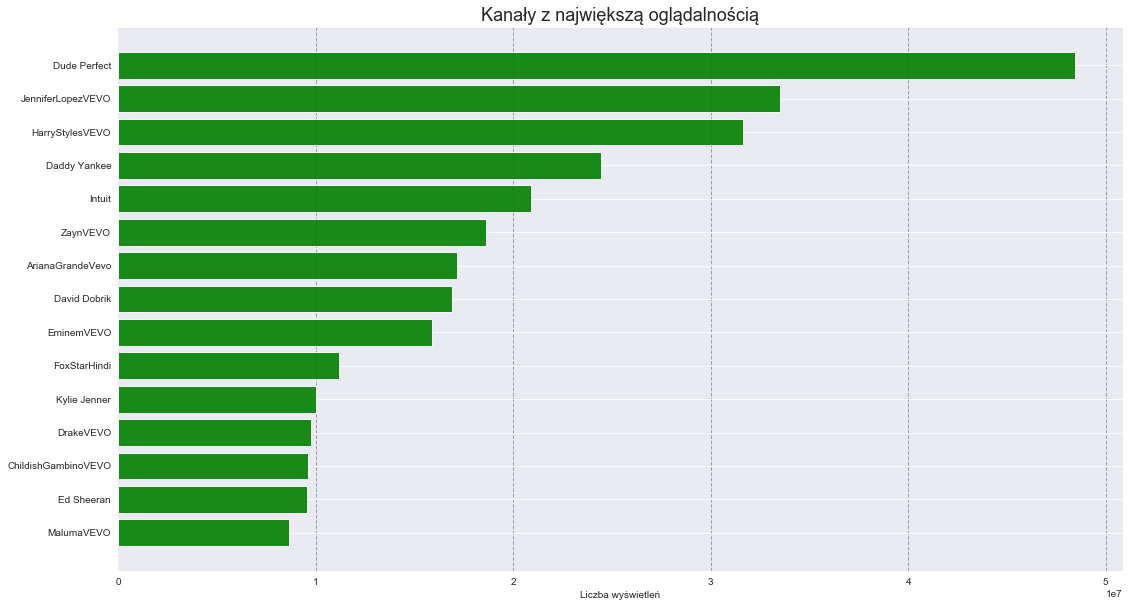

In [155]:
most_viewed_channels = "SELECT channel_title, views FROM Videos GROUP BY channel_title  ORDER BY views desc limit 15"
most_viewed_channels_df = pd.read_sql_query(most_viewed_channels, db)
fig, ax = plt.subplots(figsize=(18, 10))
_ = plt.barh(most_viewed_channels_df["channel_title"], most_viewed_channels_df["views"].sort_values(), alpha=0.9, color = "green")
_ = plt.title("Kanały z największą oglądalnością", fontsize=18)
_ = plt.xlabel("Liczba wyświetleń")
_ = plt.grid(color='grey', linestyle='--', linewidth=1, axis='x', alpha=0.7)
_ = plt.show()

# Kategorie filmików

Nazwy kategorii filmików znajdują się w osobnym pliku. Oryginalny zbiór danych zawiera tylko kod kategorii. Należy w takim przypadku dopasować nazwy kategorii z ich kodem w drugim pliku.

In [118]:
with open("US_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['category_id'].map(cat_dict)

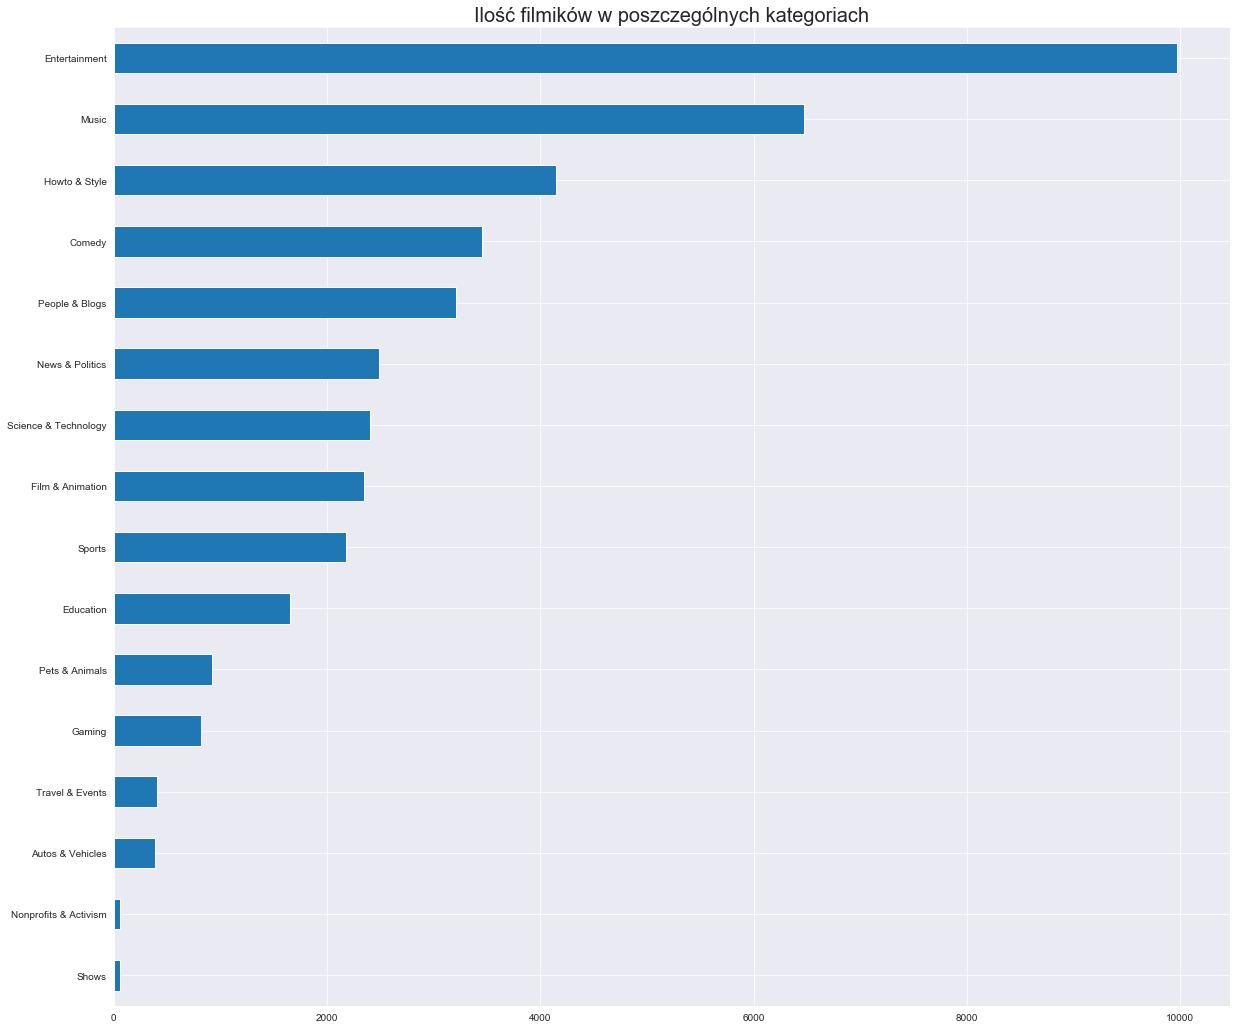

In [119]:
df['category_name'].value_counts().sort_values().plot(kind='barh', figsize=(20,18))
_ = plt.title("Ilość filmików w poszczególnych kategoriach", size=20)
_ = plt.show()

In [120]:
df.category_name.value_counts()

Entertainment            9964
Music                    6472
Howto & Style            4146
Comedy                   3457
People & Blogs           3210
News & Politics          2487
Science & Technology     2401
Film & Animation         2345
Sports                   2174
Education                1656
Pets & Animals            920
Gaming                    817
Travel & Events           402
Autos & Vehicles          384
Shows                      57
Nonprofits & Activism      57
Name: category_name, dtype: int64

Trzy najpopularnijesze kategorie filmików to Entertainment (9964 filmów), Music (6472), Howto & Style (4146).

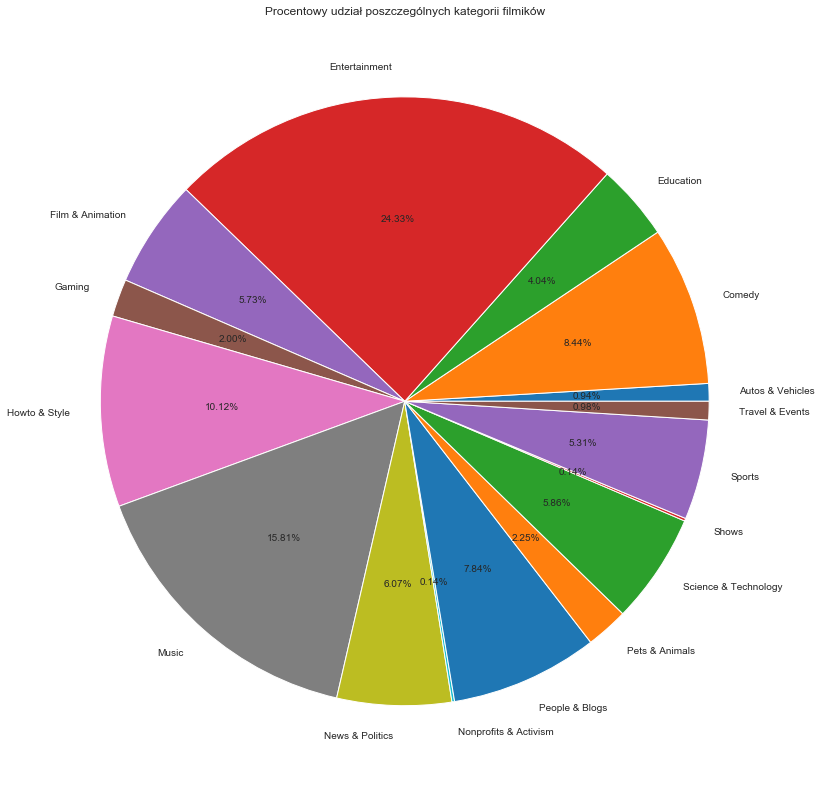

In [137]:
grouped_category =df["category_name"].value_counts(normalize = True).sort_index() * 100
_ = grouped_category.plot.pie(figsize = (14,14), autopct='%.2f%%',
                          title= "Procentowy udział poszczególnych kategorii filmików")
_ = plt.ylabel('')
_ = plt.show()

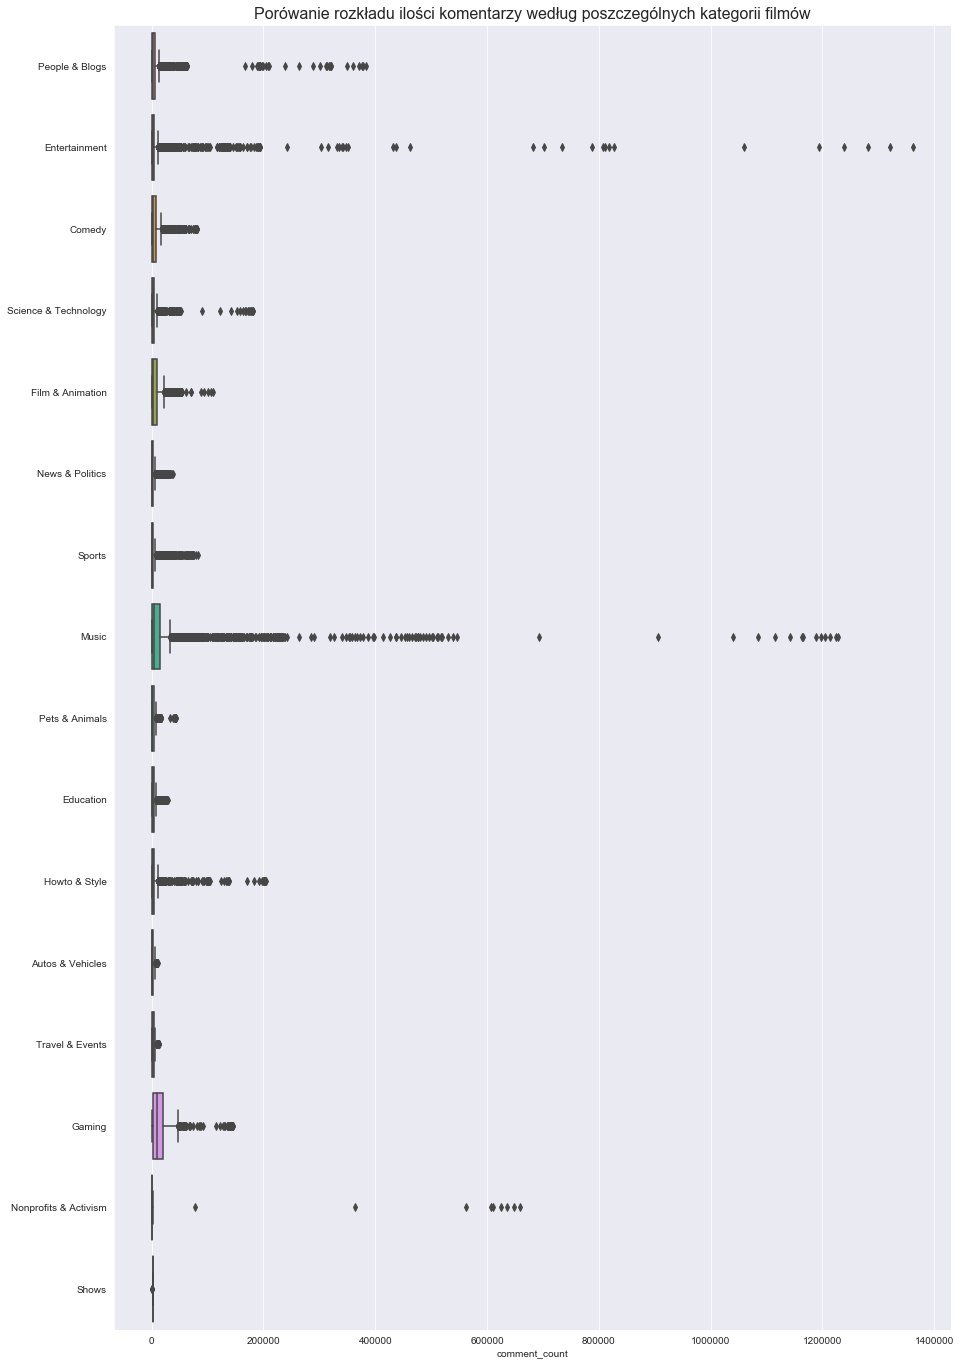

In [121]:
fig, ax = plt.subplots(figsize=(15, 24))
ax = sns.boxplot(y="category_name", x="comment_count", data=df, orient="h")
_ = plt.title("Porówanie rozkładu ilości komentarzy według poszczególnych kategorii filmów", fontsize =16)
_ = plt.ylabel('')
_ = plt.show()

In [122]:
df.groupby("category_name")["comment_count"].describe(percentiles = [0.25, .5, .75, .95])

,count,mean,std,min,25%,50%,75%,95%,max
category_name,,,,,,,,,
Autos & Vehicles,384,2043,2616,0,134,916,2585,8028,10591
Comedy,3457,6522,10423,0,894,2604,7514,26663,81051
Education,1656,3286,4798,0,772,1466,3377,15746,28835
Entertainment,9964,7383,41914,0,584,1694,4607,24197,1361580
Film & Animation,2345,7628,11823,0,548,2636,9079,34495,108849
Gaming,817,18042,27125,0,2721,8871,20246,59688,144795
Howto & Style,4146,5584,15848,0,732,1842,4814,16005,203884
Music,6472,19360,68325,0,993,3906,13980,69599,1228655
News & Politics,2487,2428,4917,0,199,866,2284,10324,38936


In [139]:
comments_by_weekday = df.groupby("publish_day")["comment_count"].sum().sort_values(ascending=False)
print(comments_by_weekday)

publish_day
Friday       81780366
Wednesday    55251983
Tuesday      52391078
Thursday     49763909
Monday       41682003
Sunday       39658706
Saturday     25360119
Name: comment_count, dtype: int64


Sumarycznie najwięcej komentarzy pojawiło się pod fimikami opublikowanym w piątek (81 780 366), a najmniej w sobotę (25 360 119). Przy uwzględnieniu ilości fimików publikowanych w danym dniu, przeciętnie na jeden filmik opublikowany w piątek przypada 11 680 komentarzy, a na filmik opublikownay w sobotę 7058.

In [152]:
df.groupby("publish_day")["category_name"].describe()

,count,unique,top,freq
publish_day,,,,
Friday,7002,16,Music,2014
Monday,6177,15,Entertainment,1560
Saturday,3593,14,Entertainment,760
Sunday,3679,15,Entertainment,913
Thursday,6950,16,Entertainment,1485
Tuesday,6786,15,Entertainment,1733
Wednesday,6762,16,Entertainment,1809


Najpopularniejsza kategoria we wszystkie dni tygodnia poza piątkiem jest Entertainment. W piątki najczęsciej publikowane są filmik w kategorii Music.

In [124]:
df.groupby("category_name")["publish_day"].describe()

,count,unique,top,freq
category_name,,,,
Autos & Vehicles,384,7,Monday,93
Comedy,3457,7,Wednesday,621
Education,1656,7,Monday,418
Entertainment,9964,7,Wednesday,1809
Film & Animation,2345,7,Tuesday,621
Gaming,817,7,Thursday,216
Howto & Style,4146,7,Wednesday,738
Music,6472,7,Friday,2014
News & Politics,2487,7,Monday,458


Około 72% wszystkich filmików w kategorii Shows jest publikowana w czwartek.
Blisko 1/3 wszystkich filmików z kategorii Music jest publikowana w piątek.
Blisko 1/4 wszystkich filmików z kategorii Autos & Vehicles jest publikowana w poniedziałek.

In [140]:
cat_list = list(df['category_name'].index)
category_summary = df.groupby("category_name")["views"].sum().sort_values(ascending=False)
print(category_summary)


category_name
Music                    40132892190
Entertainment            20604388195
Film & Animation          7284156721
Comedy                    5117426208
People & Blogs            4917191726
Sports                    4404456673
Howto & Style             4078545064
Science & Technology      3487756816
Gaming                    2141218625
News & Politics           1473765704
Education                 1180629990
Pets & Animals             764651989
Autos & Vehicles           520690717
Travel & Events            343557084
Nonprofits & Activism      168941392
Shows                       51501058
Name: views, dtype: int64


Najpopularniejsza kategoria to Music z ponad 40mld wyświetleń, druga pod względem wyświetelń to rozrywka czyli Entertainment, z blisko połową wyświetleń co najpularniejsza kategoria - 20mld wyświetleń. Na trzecim miejscu znajduje się kategoria Film & Animation - ponad 7,2mld wyświetleń.

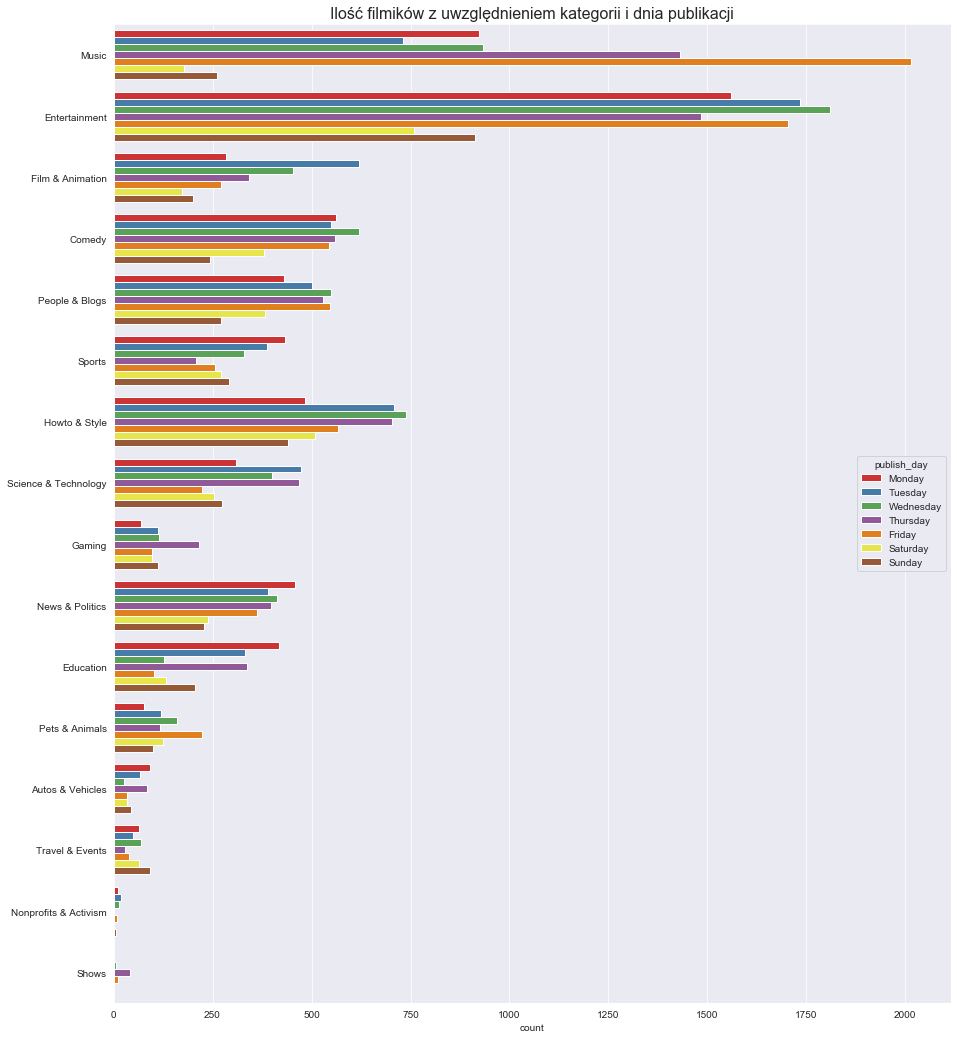

In [142]:
fig, ax = plt.subplots(figsize=(15, 18))

_ = sns.countplot(y = 'category_name', hue = 'publish_day', data = df,palette="Set1", order =cat_list, hue_order =["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
_ = plt.title("Ilość filmików z uwzględnieniem kategorii i dnia publikacji", fontsize=16)
_ = plt.ylabel('')
_ = plt.show()

# Podsumowanie:


Do ekstrakcji danych użyto dwóch sposobów ich odczytu. Pierwszy zakłada wczytanie danych do DataFrame przy użyciu biblioteki Pandas. Natomiast drugi wykorzystuje zapytania SQL do bazy SQLite. Plusem pierwszego rozwiązania jest wygodne wykorzystanie DataFrames przy użyciu kodu Pythonowego. Jednak w przypadku dużego wolumenu, rozwiązanie to może  mieć problemy wydajnościowe. 

Zbiór analizowanych filmików charakteryzuje się dużym rozrzutem wartości dla zmiennych views, likes, dislikes i comment_count

75% filmików mieści się w przedziale do 1 823 157 wyświetleń, a połowa wszystkich analizwanych filmików nie osiąga wiekszej oglądalności niż 681 861 w danym dniu badanego okresu. Jednocześnie w zestawieniu pojawiają się niewielka grupa filmików z bardzo dużą oglądalnością. Najpopularnijszy filmik był oglądany aż 225 211 923 razy.

Połowa filmików mieści się w przedziale do 18 091 polubień, a trzy czwarte wszystkich nie osiąga większej ilości polubień niż 55 417. Jednak filmik z największą ilością polubień ma ich aż 5 613 827.

Najbardziej nielubiany filmik zebrał, aż 1 674 420 dislikes. Jednak jest to wartość bardzo skrajna dla badanego zbioru. Mediana wszystkich filmików nie przekracza tylko 631 dislikes. 

Najczęściej komentowany filmik zebrał 1 361 580 komentarzy. Jednak aż 75% wszystkich filmików nie jest komentowana częściej niż 5 755 razy.

Część filmików pojawia się w zestawniu Trendings więcej niż jeden raz. Liczba obserwacji wynosi 40 494, przy czym filmików z unikalnym id jest ponad 7 razy mniej czyli 6 351.

Najsilniej pozytwnie skorelowane są ze sobą likes i views (0.85), w dalszej kolejności likes i comment_count (0.8), dislikes i comment_count  (0.7), views i comment_count (0.62).

Najczęściej publikowane są filmiki z kategorii Entertainment (9964 filmów), a w dalszej kolejności Music (6472), Howto & Style (4146). Jednak pod względem oglądaności najczęściej wyświetlane są filmiki z kategorii Music (ponad 40mld wyświetleń), druga pod względem wyświetelń Entertainment, ma  blisko połowę wyświetleń co najpularniejsza kategoria - 20 mld wyświetleń. Na trzecim miejscu znajduje się kategoria Film & Animation - ponad 7,2mld wyświetleń.

Najczęściej pojawiającym się kanałem jest ESPN (w zestaweniu 203 razy), a w dalszej kolejności The Tonight Show Starring Jimmy Fallon (197 razy) i Netflix (193). 